# 的検出

### 手順の確認  
1. 的となる四角い白を検出
2. その板を正面から見た様に変形  
3. 開いた穴を認識する

1----問題は写真の中から板をどうやって検出するか。  
=> 複数のフィルターをかけて最大面積を検出すれば良い  
2----問題はしっかり上下左右を守らない場合、四角が検出できなかった場合  
3----穴の認識には何を用いるか(明度?)

In [1]:
# -*- coding:utf-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# グレースケール画像の準備
img        = cv2.imread('data/target7.jpg')
img_blur   = cv2.GaussianBlur(img, (5,5), 0)
img_gray   = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
th, img_bi = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY)

### RGB

In [3]:
def get_th_rgb(img,r1,g1,b1,r2,g2,b2):
    img_rgb = img.copy()                            # rgbスケール
    rgb_min = np.array([r1,g1,b1], np.uint8)
    rgb_max = np.array([r2,g2,b2], np.uint8)
    th      = cv2.inRange(img_rgb, rgb_min, rgb_max)
    return th

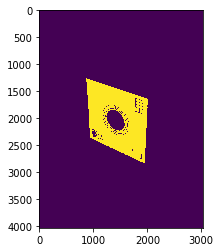

In [4]:
th1 = get_th_rgb(img_blur,40, 105, 145, 90, 145, 200)
plt.imshow(th1)

### HSV

In [5]:
def get_th_hsv(img,h1,s1,v1,h2,s2,v2):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # hsvスケール
    hsv_min = np.array([h1,s1,v1], np.uint8)
    hsv_max = np.array([h2,s2,v2], np.uint8)
    th      = cv2.inRange(img_hsv, hsv_min, hsv_max)
    return th

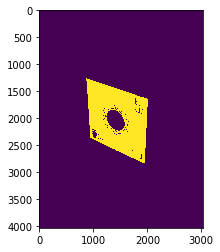

In [6]:
th2 = get_th_hsv(img_blur,90 ,130 ,120 ,130 ,175 ,220)
plt.imshow(th2)

### Adaptive Threshold

In [7]:
def get_th_ad1(img_gray, Block_Size, C):
    th = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, Block_Size, C) # ブロック数, 引く数
    return th

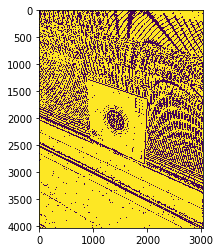

In [8]:
th3 = get_th_ad1(img_gray, 39, 3)
plt.imshow(th3)

### 合成フィルター

In [9]:
def get_th(img):
    # グレースケール画像の準備
    img_blur   = cv2.GaussianBlur(img, (5,5), 0)
    img_gray   = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    
    th1 = get_th_rgb(img_blur,40,105,145,90,145,200)   # rgb
    th2 = get_th_hsv(img_blur,90,130,120,130,175,220)  # hsv
    th3 = get_th_ad1(img_gray,39,3)                    # ad

    th = cv2.bitwise_and(th1,th2)
    th = cv2.bitwise_and(th, th3)
    return th

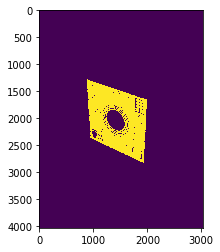

In [10]:
th = get_th(img)
plt.imshow(th)

## 最大面積の取得

In [11]:
def get_contours(th):
    _, contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [34]:
def get_max_cnt(th):
    # 輪郭を取得
    contours = get_contours(th)
    if(len(contours)==0):
        width,height = th.shape
        return np.array([[[0,0]],[[0,width]],[[height,width]],[[height,0]]])
    
    # 最大輪郭を取得
    cnt_list = np.array([cv2.moments(cnt)['m00'] for cnt in contours]) # 各cntの面積リスト
    index    = np.argmax(cnt_list)  # 面積最大の指標
    max_cnt  = contours[index]      # 最大cntを取得
    
    # 最大輪郭の近似(滑らかにする)
    epsilon = 0.1*cv2.arcLength(max_cnt,True)
    max_cnt = cv2.approxPolyDP(max_cnt,epsilon,True)
    return max_cnt

総輪郭数: 15
最大図形が四角形
頂点: [288 144],[279 199],[225 202],[284 200]


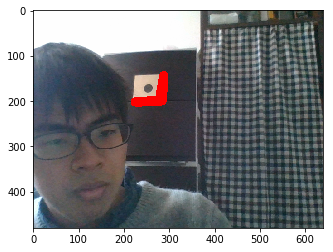

In [35]:
contours = get_contours(th)
cnt      = get_max_cnt(th)

print("総輪郭数: {}".format(len(contours)))
if(len(cnt)==4):
    print("最大図形が四角形")
    print("頂点: {},{},{},{}".format(cnt[0,0],cnt[1,0],cnt[2,0],cnt[3,0]))
else:
    print("最大図形が四角でない")
    print("頂点数: {}".format(len(cnt)))
    
img_cnt = cv2.drawContours(img.copy(), [cnt], 0, (0,0,255), 20)
plt.imshow(cv2.cvtColor(img_cnt,cv2.COLOR_BGR2RGB))

## 斜めから正面に変換
四角形を切り抜き$300\times300$の画像に変換する

In [14]:
def get_target(img,cnt):
    if(len(cnt)==4):
        # 頂点座標の整理
        cnt = cnt.tolist()
        cnt.sort(key=lambda x:x[0][0]+x[0][1])
        cnt = np.array(cnt)
        # 切り出し箇所
        pts1 = np.float32([[cnt[0,0,0],cnt[0,0,1]],  # 左上点
                           [cnt[1,0,0],cnt[1,0,1]],  # 右上点
                           [cnt[2,0,0],cnt[2,0,1]],  # 左下点
                           [cnt[3,0,0],cnt[3,0,1]]]) # 右下点
        pts2 = np.float32([[0,0],[0,300],[300,0],[300,300]]) # 切り出し後サイズ
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,(300,300))
        return dst
    else:
        return np.zeros((300,300))

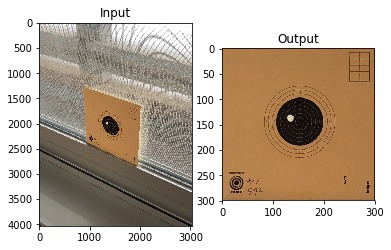

In [15]:
target = get_target(img,cnt)
plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Input')
plt.subplot(122),plt.imshow(cv2.cvtColor(target,cv2.COLOR_BGR2RGB)),plt.title('Output')
plt.show()

後でここまでのクオリティを上げれるだけ上げる

## 穴の位置を特定
複数の検出法を調べないと  
二値化してテンプレートマッチングとか  
[穴検出](http://blog.sigbus.info/2011/11/opencv.html)

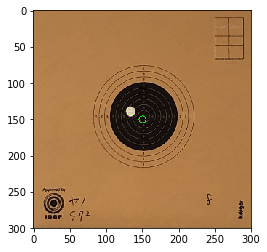

In [16]:
target_center = cv2.circle(target.copy(),(150,150),5,(0,255,0),1) # 中心位置を描画
plt.imshow(cv2.cvtColor(target_center,cv2.COLOR_BGR2RGB))

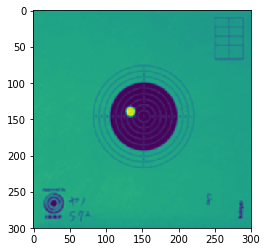

In [17]:
target_blur = cv2.GaussianBlur(target, (5,5), 0)
target_gray = cv2.cvtColor(target_blur,cv2.COLOR_BGR2GRAY)
plt.imshow(target_gray)

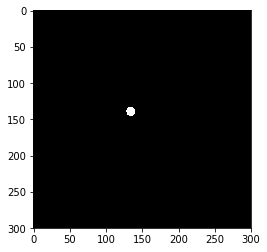

In [18]:
th, target_th = cv2.threshold(target_gray, 150, 255, cv2.THRESH_BINARY) # 200～255 => 255
plt.imshow(cv2.cvtColor(target_th, cv2.COLOR_GRAY2RGB))

### テンプレートマッチング
うまく環境調節したらここいらないんじゃないかと思った  
普通に上の画像の白い部分の重心位置を考えれば良いんじゃね  
=> 穴が重なった場合でも分けて考えられるというメリットがある

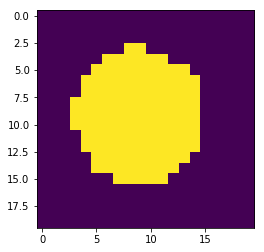

In [19]:
template = target_th[130:150,125:145]
plt.imshow(template)
#cv2.imwrite("data/templaete.jpg",template)

テンプレートマッチングで類似度を表すresを返す  
resの値は-1から+1なので二値化の仕方に注意

In [20]:
def template_matting(img_gray, template):
    res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
    return res

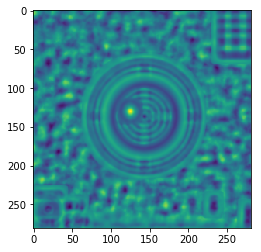

In [21]:
res = template_matting(target_gray, template)
plt.imshow(res)

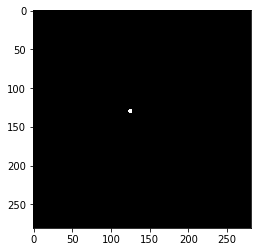

In [22]:
threshold  = 0.7
th, res_th = cv2.threshold(res, threshold, 255, cv2.THRESH_BINARY) # threshold～255 => 255
res_th     = np.array(res_th, np.uint8)                            # ちょっと型合わせ
plt.imshow(cv2.cvtColor(res_th, cv2.COLOR_GRAY2RGB))

## 輪郭検出して重心位置を出す
テンプレートマッチングの`res_th`はうまくいかなかったので元の`target_th`を用いた  
重心位置を出すのは`moments`を利用する

In [23]:
contours = get_contours(target_th)
print("穴の数: {}".format(len(contours)))

穴の数: 1


133 139


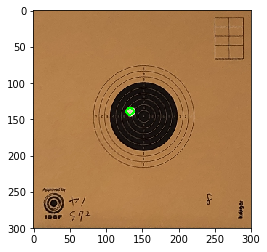

In [24]:
cnt = contours[0]
M   = cv2.moments(cnt)
x,y = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
print(x,y)
target_hole = cv2.circle(target.copy(),(x,y),5,(0,255,0),2) # 中心位置を描画
plt.imshow(cv2.cvtColor(target_hole,cv2.COLOR_BGR2RGB))

## 画像受け取って二値化して穴の重心返す関数
受け取る画像はBGR

In [25]:
def get_hole_pos(target):
    target_blur   = cv2.GaussianBlur(target, (5,5), 0)                      # ガウスぼかし
    target_gray   = cv2.cvtColor(target_blur,cv2.COLOR_BGR2GRAY)            # グレースケール
    th, target_th = cv2.threshold(target_gray, 150, 255, cv2.THRESH_BINARY) # 二値化 (200～255 => 255)
    contours = get_contours(target_th)                                      # 輪郭検出
    hole_pos = [(int(cv2.moments(cnt)["m10"]/cv2.moments(cnt)["m00"]),
                 int(cv2.moments(cnt)["m01"]/cv2.moments(cnt)["m00"])) for cnt in contours]
    return hole_pos

In [26]:
get_hole_pos(target)

[(133, 139)]

## Webカメラで実行
これはテスト用なのでいろいろな要素を表示する

In [36]:
# 0 => IVcan, 1 => Webカメラ
cap = cv2.VideoCapture(1)

while True:
    ret, img = cap.read()          # フレームの読み込み
    th       = get_th(img)         # 白っぽい部分を取得
    cnt      = get_max_cnt(th)     # 最大部分を囲む矩形
    target   = get_target(img,cnt) # 的の板を正面にする
    img_rect = cv2.drawContours(img.copy(), [cnt], 0, (255,0,0), 12)
    
#     hole_pos = get_hole_pos(target)
#     for hole in hole_pos:
#         target_hole = cv2.circle(target.copy(),(hole[0],hole[1]),5,(0,255,0),2) # 中心位置を描画
    
    # 画像を表示する
    cv2.imshow('th', th)
    cv2.imshow('img_rect', img_rect)
    cv2.imshow('target', target)
    #plt.imshow(cv2.cvtColor(target_hole,cv2.COLOR_BGR2RGB))

    # キー入力を1ms待って、kが27(Esc)だったらbreakする
    k = cv2.waitKey(1)
    if k == 27:
        break

# キャプチャをリリースして、ウィンドウを全て閉じる
cap.release()
cv2.destroyAllWindows()

In [32]:
def get_th(img):
    # グレースケール画像の準備
    img_blur   = cv2.GaussianBlur(img, (5,5), 0)
    img_gray   = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    
    th1 = get_th_rgb(img_blur,85,110,130,160,175,200)   # rgb
    th2 = get_th_hsv(img_blur,90,45,105,125,100,205)  # hsv
    th3 = get_th_ad1(img_gray,35,3)                    # ad

    th = cv2.bitwise_and(th1,th2)
    th = cv2.bitwise_and(th, th3)
    return th